In [5]:
using LinearAlgebra
using Convex
using ECOS
using Plots

In [6]:
n = 4; #number of dimensions in state vector
m = 2; #number of dimensions in action vector

In [7]:
function initializer(xInitial,xFinal,minX,maxX,minY,maxY,obsTraj,rTotal,N,agentRadius,conservative=false)
    
    print("Initializing trajectory solver\n")

    if conservative
        return repeat(xInitial,1,N) #constant repetitions of original value
    end
    
    obstacles = size(rTotal)[2]; #total number of obstacles (incl. other agents) to dodge
    
    xt = hcat(LinRange(xInitial,xFinal,N)...); # vector of vectors with initial guess of locations
    
    # Loop Control
    diff = Inf; #initialize to unreasonable value to overwrite in loop
    epsilon = 1e-3; #tolerance for convergence of solution
    
    optval = Inf; # objective function value
    iter = 0; # number of iterations of convex solver
    
    x = Variable(n,N); #state vectors arranged as matrix
    
    while abs(diff) > epsilon && iter <= 150
        # Initial and final position constraints
        constraints = [x[:,1] == xInitial]; #initialize constraints list with initial position
        constraints = cat(constraints,[x[:,N] == xFinal],dims=1); #hard constraint on final position
        
        # Work space constraints
        constraints = cat(constraints,[x[2,:] >= minY + agentRadius, x[2,:] <= maxY - agentRadius],dims=1) # Y axis
        constraints = cat(constraints,[x[1,:] >= minX + agentRadius, x[1,:] <= maxX - agentRadius],dims=1) # X axis
        
        # Obstacle avoidance constraints
        zt = xt[1:2,:]; #isolated positional values, 2xN matrix
        
        zSub = repeat(zt,1,1,obstacles) - obsTraj #2xNxO tensor containing diffferences between each position in the trajectory and position of each obstacle center
        xSub = zSub[1,:,:] #NxO matrix
        ySub = zSub[2,:,:] #NxO matrix
        
        zDiffs = x[1:2,:] - zt #2xN matrix, difference between current and prior position trajectory
        xDiffs = zDiffs[1,:] # 1xN vector
        yDiffs = zDiffs[2,:] # 1xN vector
        
        zSubNorms = sqrt.(sum(zSub.^2,dims=1))[1,:,:] #NxO matrix of Euclidean distances between each position in the trajectory and each obstacle center
        
        for o in 1:obstacles
            constraints = cat(constraints,[rTotal[:,o] - zSubNorms[:,o] - (xSub[:,o].* xDiffs' + ySub[:,o].* yDiffs')./zSubNorms[:,o] <= 0],dims=1) #o-th obstacle avoidance constraint
        end
        
        problem = minimize(sumsquares(x[:,2:N] - x[:,1:N-1]), constraints)
            
        solve!(problem, ECOS.Optimizer)
        
        mincost = problem.optval;
        
        print("initializer opt :",mincost,"\n") #monitor
        print("initializer problem status: ",problem.status,"\n")

        diff = maximum(abs.(x.value - xt)) #for checking convergence of trajectory solution
        
        if problem.status == "INFEASIBLE" #if bad information from the environment provokes an infeasible solve, don't crash
            xt = initializer(xInitial,xFinal,minX,maxX,minY,maxY,obsTraj,rTotal,N,agentRadius,conservative=true)
        else
            xt = copy(x.value); #for use in following iteration
        end

        zt = x[1:2,:] #ACTIVATE FOR OBSTACLE AVOIDANCE CONSTRAINTS
        print("initializer convergence measure: ",diff,"\n") #monitor
        iter += 1;

    end

#     print("initializer optimal value: ",mincost)

    return xt
    
end

initializer (generic function with 2 methods)

In [8]:
xFirst = [1.0;2.0;0.0;0.0];
xLast = [1.99;1.0;0.0;0.0];

numSteps = 20; #number of time steps

Xmin = -50;
Xmax = 50;
Ymin = -50;
Ymax = 50;

obsTraj = cat(repeat([1.5;1.5],1,numSteps),dims=3);#2xNxO tensor detailing trajectory of each obstacle in x,y
rTotal = 0.3*ones(numSteps,1);#NxO matrix detailing radius of each obstacle, plus radius of agent, repeated N times

radius = 0.1;

trajectoryTest = initializer(xFirst,xLast,Xmin,Xmax,Ymin,Ymax,obsTraj,rTotal,numSteps,radius)

Initializing trajectory solver
initializer opt :0.3540523263305379
initializer problem status: OPTIMAL
initializer convergence measure: 0.4505973702925685

ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.986e+03  +4e+03  1e-02  5e-01  1e+00  4e+01    ---    ---    1  1  - |  -  - 
 1  +8.859e-02  -2.201e+02  +2e+02  7e-04  7e-02  6e-02  2e+00  0.9436  1e-04   1  1  1 |  0  0
 2  +1.143e-01  -2.042e+02  +2e+02  7e-04  4e-02  1e-01  2e+00  0.1126  3e-01   1  1  1 |  0  0
 3  +1.466e-01  -2.023e+02  +2e+02  7e-04  1e-02  2e-01  2e+00  0.0454  7e-01   1  1  2 |  0  0
 4  +2.148e-01  -1.727e+02  +2e+02  6e-04  5e-03  2e-01  2e+00  0.2005  2e-01   1  1  1 |  0  0
 5  +5.116e-01  -1.491e+02  +2e+02  5e-04  2e-03  4e-01  1e+00  0.2442  4e-01   1  1  2 |  0  0
 6  +7.884e-01  -5.500e+01  +6e+01  2e-04  5e-04  2e-01  6e-01  0.7095  1e-01   1  

4×20 Array{Float64,2}:
 1.0  1.02743  1.05486  1.08229  1.10972  …  1.76313  1.83876  1.91438  1.99
 2.0  1.92422  1.84844  1.77266  1.69689     1.08359  1.05573  1.02786  1.0 
 0.0  0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0 
 0.0  0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0 

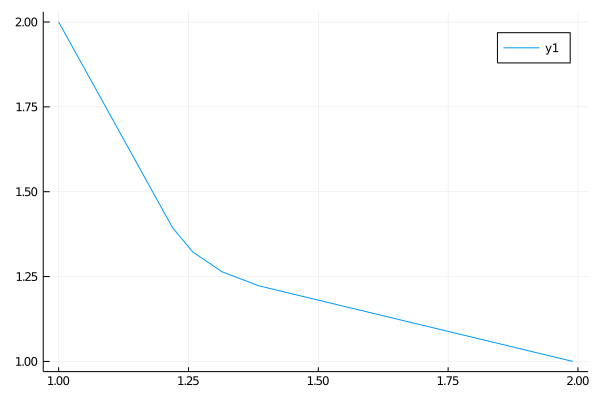

In [9]:
using Plots
plot(trajectoryTest[1,:],trajectoryTest[2,:])

In [93]:
function trajPlan(xInitial,xFinal,minX,maxX,minY,maxY,obsTraj,rTotal,N,agentRadius)
    
    obstacles = size(rTotal)[2]; #total number of obstacles (incl. other agents) to dodge
    
    xt = initializer(xInitial,xFinal,minX,maxX,minY,maxY,obsTraj,rTotal,N,agentRadius); # vector of vectors with initial guess of locations
    
    # Loop Control
    diff = Inf; #initialize to unreasonable value to overwrite in loop
    epsilon = 1e-3; #tolerance for convergence of solution
    
    optval = Inf; # objective function value
    iter = 0; # number of iterations of convex solver
    
    x = Variable(n,N); #state vectors arranged as matrix
    u = Variable(m,N); #action vectors arranged as matrix
    dt = 0.1; #time difference between time steps
    
    
    while abs(diff) > epsilon && iter <= 150

        # Original objective function
        objective = norm((x[:,N] - xFinal).*[10;10;1;1],1) + dt*square(norm(vec(u)));
        
        # Initial and final position constraints
        constraints = [x[:,1] == xInitial]; #initialize constraints list with initial position
#         constraints = cat(constraints,[x[:,N] == xFinal],dims=1); #hard constraint on final position
        
        # Work space constraints
        constraints = cat(constraints,[x[2,:] >= minY + agentRadius, x[2,:] <= maxY - agentRadius],dims=1) # Y axis
        constraints = cat(constraints,[x[1,:] >= minX + agentRadius, x[1,:] <= maxX - agentRadius],dims=1) # X axis
                
        # Control inputs
        constraints = cat(constraints,[x[3,2:N] == x[3,1:N-1] + dt*u[1,1:N-1]],dims=1) #acceleration
        constraints = cat(constraints,[x[4,2:N] == x[4,1:N-1] + dt*u[2,1:N-1]],dims=1) #steering angle
        
        # Dynamics constraints
#         prev_psi = reshape(xt[4,:],1,:); #history of headings
#         prev_veloc = reshape(xt[3,:],1,:); #history of velocities      
        prev_psi = xt[4,:];
        prev_veloc = xt[3,:];
              
        for steppin in 1:N-1
            constraints = cat(constraints,[x[1,steppin+1] == x[1,steppin] + dt*(x[3,steppin]*cos(prev_psi[steppin]) - prev_veloc[steppin]*sin(prev_psi[steppin])*(x[4,steppin]-prev_psi[steppin]))],dims=1)
#             constraints = cat(constraints,[x[1,steppin+1] == x[1,steppin] + dt*(x[3,1]*cos(prev_psi[1,1]) - prev_veloc[1,1]*sin(prev_psi[1,1])*(x[4,1]-prev_psi[1,1]))],dims=1)
            constraints = cat(constraints,[x[2,steppin+1] == x[2,steppin] + dt*(x[3,steppin]*sin(prev_psi[steppin]) + prev_veloc[steppin]*cos(prev_psi[steppin])*(x[4,steppin]-prev_psi[steppin]))],dims=1) #y position change

        end
        
#         constraints = cat(constraints,[x[1,2:N] == x[1,1:N-1] + dt*(x[3,1:N-1].*reshape(cos.(prev_psi[:,1:N-1]),1,:) - prev_veloc[:,1:N-1].*reshape(sin.(prev_psi[:,1:N-1]),1,:).*(x[4,1:N-1]-prev_psi[:,1:N-1]))],dims=1) #x position change
#         constraints = cat(constraints,[x[2,2:N] == x[2,1:N-1] + dt*x[3,1:N-1].*sin.(prev_psi[:,1:N-1]) + dt*prev_veloc[:,1:N-1].*cos.(prev_psi[:,1:N-1]).*(x[4,1:N-1]-prev_psi[:,1:N-1])],dims=1) #y position change
        
        # Obstacle avoidance constraints
        zt = xt[1:2,:]; #isolated positional values, 2xN matrix
        
        zSub = repeat(zt,1,1,obstacles) - obsTraj #2xNxO tensor containing diffferences between each position in the trajectory and position of each obstacle center
        xSub = zSub[1,:,:] #NxO matrix
        ySub = zSub[2,:,:] #NxO matrix
        
        zDiffs = x[1:2,:] - zt #2xN matrix, difference between current and prior position trajectory
        xDiffs = zDiffs[1,:] # 1xN vector
        yDiffs = zDiffs[2,:] # 1xN vector
        
        zSubNorms = sqrt.(sum(zSub.^2,dims=1))[1,:,:] #NxO matrix of Euclidean distances between each position in the trajectory and each obstacle center
        
        for o in 1:obstacles
#             constraints = cat(constraints,[rTotal[:,o] - zSubNorms[:,o] - (xSub[:,o].* xDiffs' + ySub[:,o].* yDiffs')./zSubNorms[:,o] <= 0],dims=1) #o-th obstacle avoidance constraint
            objective += 10*sum(max(0.1 .+ rTotal[:,o] - zSubNorms[:,o] - (xSub[:,o].* xDiffs' + ySub[:,o].* yDiffs')./zSubNorms[:,o],0)) #soft version of obstacle avoidance constraints
        end
        
        problem = minimize(objective, constraints)
            
        solve!(problem, ECOS.Optimizer)
        
        mincost = problem.optval;
        
        print("Trajectory solver opt :",mincost,"\n") #monitor
        print("Trajectory solver problem status: ",problem.status,"\n")

        diff = maximum(abs.(x.value - xt)) #for checking convergence of trajectory solution
        
        if problem.status == "INFEASIBLE" #if bad information from the environment provokes an infeasible solve, don't crash
            xt = initializer(xInitial,xFinal,minX,maxX,minY,maxY,obsTraj,rTotal,N,agentRadius,conservative=true)
        else
            xt = copy(x.value); #for use in following iteration
#             ut = copy(u.value); #for output
        end

        zt = x[1:2,:] #ACTIVATE FOR OBSTACLE AVOIDANCE CONSTRAINTS
        print("Trajectory solver convergence measure: ",diff,"\n") #monitor
        iter += 1;

    end

    return xt #,ut
end

trajPlan (generic function with 1 method)

In [94]:
carTrajectoryTest = trajPlan(xFirst,xLast,Xmin,Xmax,Ymin,Ymax,obsTraj,rTotal,numSteps,radius)

Initializing trajectory solver
initializer opt :0.3540523263305379
initializer problem status: OPTIMAL
initializer convergence measure: 0.4505973702925685

ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.986e+03  +4e+03  1e-02  5e-01  1e+00  4e+01    ---    ---    1  1  - |  -  - 
 1  +8.859e-02  -2.201e+02  +2e+02  7e-04  7e-02  6e-02  2e+00  0.9436  1e-04   1  1  1 |  0  0
 2  +1.143e-01  -2.042e+02  +2e+02  7e-04  4e-02  1e-01  2e+00  0.1126  3e-01   1  1  1 |  0  0
 3  +1.466e-01  -2.023e+02  +2e+02  7e-04  1e-02  2e-01  2e+00  0.0454  7e-01   1  1  2 |  0  0
 4  +2.148e-01  -1.727e+02  +2e+02  6e-04  5e-03  2e-01  2e+00  0.2005  2e-01   1  1  1 |  0  0
 5  +5.116e-01  -1.491e+02  +2e+02  5e-04  2e-03  4e-01  1e+00  0.2442  4e-01   1  1  2 |  0  0
 6  +7.884e-01  -5.500e+01  +6e+01  2e-04  5e-04  2e-01  6e-01  0.7095  1e-01   1  

Trajectory solver opt :82.18107471045748
Trajectory solver problem status: OPTIMAL
Trajectory solver convergence measure: 1.7694450929525727
-01  0.0127  8e-01   1  1  2 |  0  0
 9  +5.833e-01  -2.814e+01  +3e+01  9e-05  2e-04  2e-01  3e-01  0.7697  3e-01   1  1  1 |  0  0
10  +7.116e-01  -1.587e+01  +2e+01  5e-05  1e-04  1e-01  2e-01  0.6308  3e-01   2  2  2 |  0  0
11  +3.191e-01  -3.377e+00  +4e+00  1e-05  5e-05  3e-02  4e-02  0.8590  1e-01   1  1  1 |  0  0
12  +1.762e-01  -7.162e-01  +9e-01  3e-06  1e-05  9e-03  9e-03  0.9890  2e-01   1  2  2 |  0  0
13  +1.373e-01  -7.458e-02  +2e-01  7e-07  4e-06  2e-03  2e-03  0.8143  6e-02   1  2  1 |  0  0
14  +1.297e-01  +5.375e-02  +8e-02  2e-07  1e-06  7e-04  8e-04  0.9399  3e-01   1  1  1 |  0  0
15  +1.253e-01  +8.869e-02  +4e-02  1e-07  7e-07  4e-04  4e-04  0.7243  3e-01   1  1  1 |  0  0
16  +1.241e-01  +1.163e-01  +8e-03  2e-08  2e-07  8e-05  8e-05  0.8515  8e-02   1  1  1 |  0  0
17  +1.238e-01  +1.228e-01  +1e-03  3e-09  2e-08  9e-0

17  +6.916e+00  +6.912e+00  +5e-03  2e-08  6e-08  4e-05  4e-05  0.9470  1e-01   1  1  1 |  0  Trajectory solver opt :6.9154048769191885
Trajectory solver problem status: OPTIMAL
Trajectory solver convergence measure: 0.43193972214603615
Trajectory solver opt :6.147925891899084
Trajectory solver problem status: OPTIMAL
Trajectory solver convergence measure: 0.18403041503474893
0
18  +6.916e+00  +6.915e+00  +7e-04  3e-09  8e-09  4e-06  5e-06  0.8876  2e-02   2  1  1 |  0  0
19  +6.915e+00  +6.915e+00  +4e-05  1e-10  4e-10  2e-07  3e-07  0.9888  4e-02   2  2  1 |  0  0
20  +6.915e+00  +6.915e+00  +9e-07  1e-11  1e-11  6e-09  7e-09  0.9753  1e-04   2  1  2 |  0  0
21  +6.915e+00  +6.915e+00  +4e-08  2e-12  4e-13  2e-10  3e-10  0.9652  7e-03   2  2  2 |  0  0

OPTIMAL (within feastol=2.1e-12, reltol=5.3e-09, abstol=3.7e-08).
Runtime: 0.002723 seconds.


ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres   

22  +6.168e+00  +6.168e+00  +7e-0Trajectory solver opt :6.16838873592925
Trajectory solver problem status: OPTIMAL
Trajectory solver convergence measure: 0.0007699605649329477
9  8e-13  9e-14  4e-11  5e-11  0.9449  3e-04   3  1  2 |  0  0

OPTIMAL (within feastol=8.4e-13, reltol=1.1e-09, abstol=6.8e-09).
Runtime: 0.002656 seconds.



4×20 Array{Float64,2}:
  1.0          1.0         1.01909     …   1.96953   1.97923   1.99   
  2.0          2.0         2.00012         1.23311   1.11486   1.0    
  2.76954e-13  0.190855    0.361726        1.18649   1.15365   1.10365
 -2.35244e-13  0.00619592  0.00808686     -1.48894  -1.47734  -1.42734

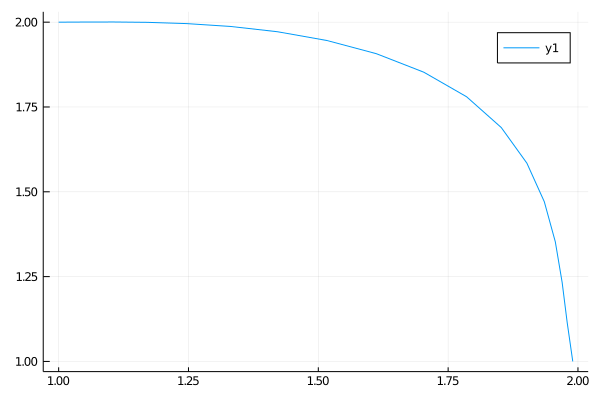

In [95]:
plot(carTrajectoryTest[1,:],carTrajectoryTest[2,:])